/tmp/ipykernel_10240/3518461196.py:88: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  axes[row_idx, col_idx].set_xlim(
/tmp/ipykernel_10240/3518461196.py:103: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  axes[row_idx + 1, col_idx].set_xlim(


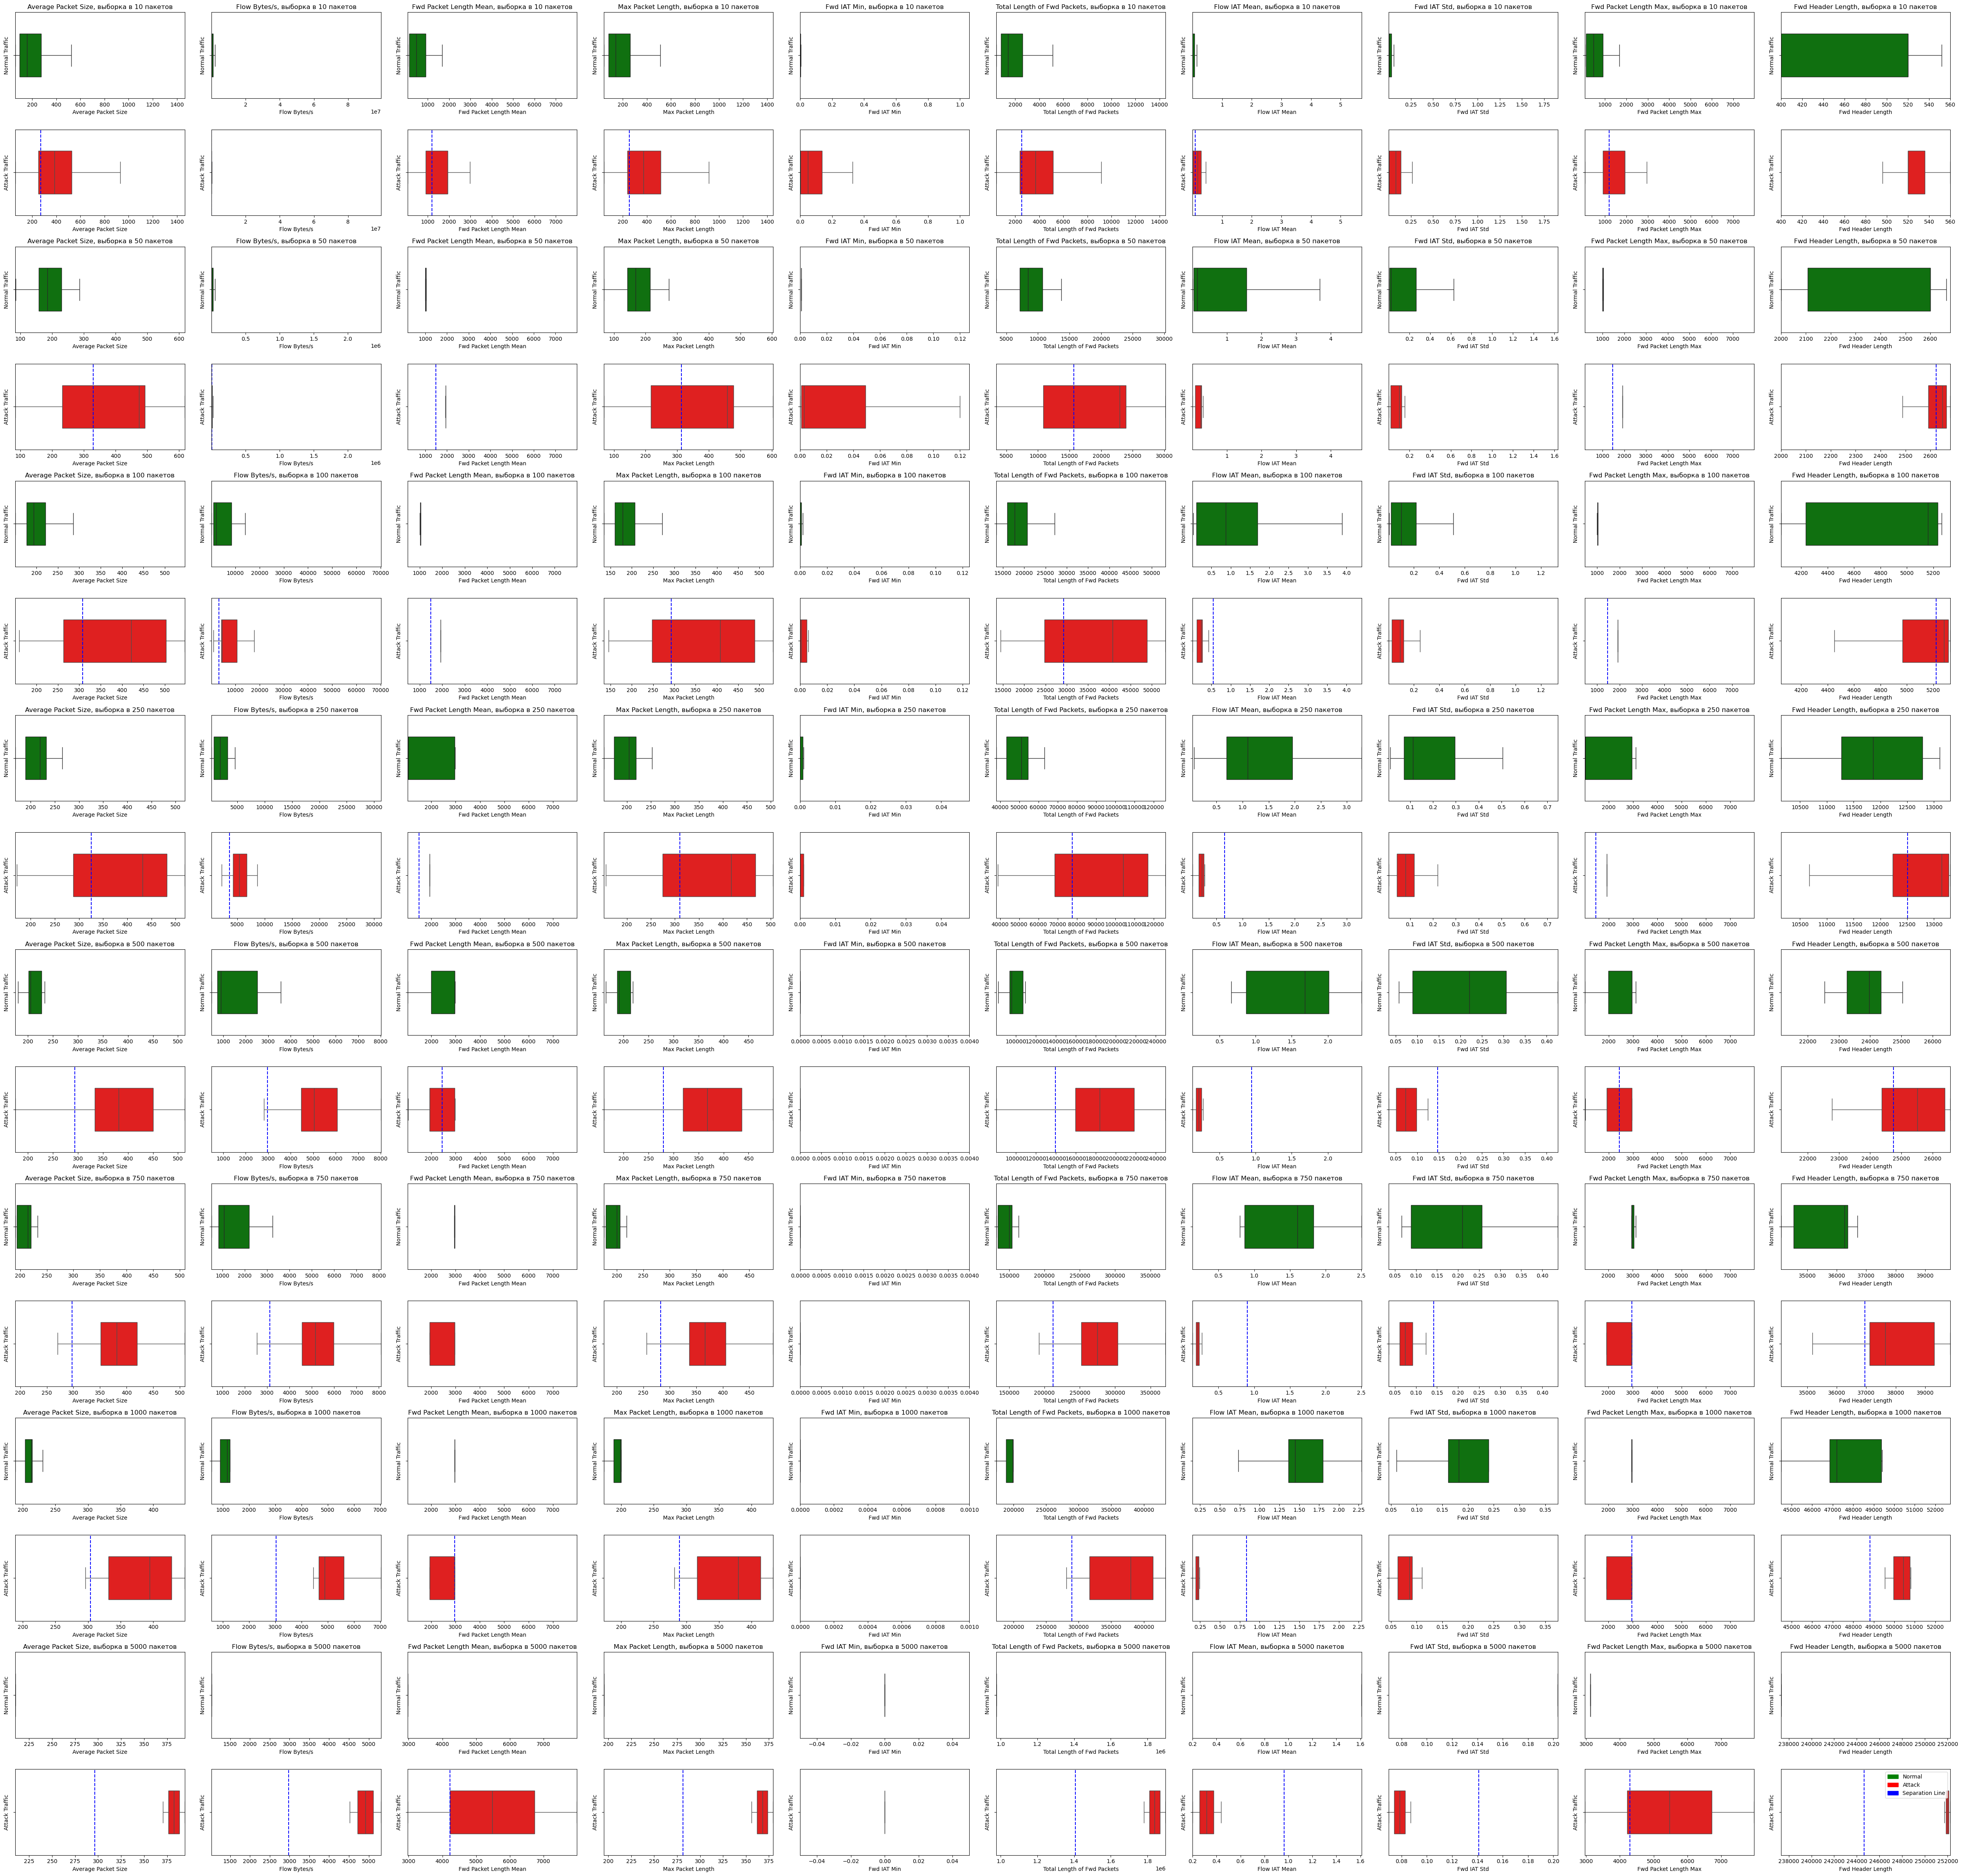

In [8]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import matplotlib.patches as mpatches


def plot_horizontal_boxplots_for_pairs(attack_dir, normal_dir):
    # Словарь для хранения пар файлов по длине выборки
    pairs = defaultdict(lambda: {"attack": [], "normal": []})

    # Сопоставление файлов из папки attack и normal по длине выборки
    for file in os.listdir(attack_dir):
        if "_1_" in file:
            length = int(file.split("_")[-3])
            pairs[length]["attack"].append(file)

    for file in os.listdir(normal_dir):
        if "_0_" in file:
            length = int(file.split("_")[-3])
            pairs[length]["normal"].append(file)

    # Подсчет общего количества наборов
    total_pairs = 0

    # Определение столбцов на основе первого набора данных
    for length, file_pairs in pairs.items():
        attack_file = sorted(file_pairs["attack"])
        normal_file = sorted(file_pairs["normal"])

        # Убедимся, что количество парных файлов совпадает
        if len(attack_file) == len(normal_file):
            attack_path = os.path.join(attack_dir, attack_file[0])

            # Загрузка данных из файлов CSV
            df_attack = pd.read_csv(attack_path)

            # Получаем список всех столбцов, кроме 'Label' и 'Index'
            columns = [
                col for col in df_attack.columns if col not in ["Label", "Index"]
            ]
            # Считаем, сколько будет строк из горизонтальных подграфиков в итоговом полотне
            total_pairs += 1

    # Создание общего полотна для всех пар файлов (две строки на пару — для нормального и атакующего трафика)
    fig, axes = plt.subplots(
        2 * total_pairs, len(columns), figsize=(5 * len(columns), 6 * total_pairs)
    )

    # Индекс для строк подграфиков
    row_idx = 0

    # Построение графиков для каждого набора пар
    for length, file_pairs in sorted(pairs.items()):
        attack_file = sorted(file_pairs["attack"])
        normal_file = sorted(file_pairs["normal"])

        # Убедимся, что количество парных файлов совпадает
        if len(attack_file) == len(normal_file):
            attack_path = os.path.join(attack_dir, attack_file[0])
            normal_path = os.path.join(normal_dir, normal_file[0])

            # Загрузка данных из файлов CSV
            df_attack = pd.read_csv(attack_path)
            df_normal = pd.read_csv(normal_path)

            # Создание подграфиков в строке
            for col_idx, column in enumerate(columns):
                # Получение минимальных и максимальных значений для нормализации масштаба оси X
                min_val = min(df_normal[column].min(), df_attack[column].min())
                max_val = max(df_normal[column].max(), df_attack[column].max())

                # Создаем boxplot для нормального трафика на верхнем уровне (первая строка)
                sns.boxplot(
                    x=df_normal[column],
                    ax=axes[row_idx, col_idx],
                    color="green",
                    orient="h",
                    width=0.5,
                    fliersize=0,
                )
                axes[row_idx, col_idx].set_title(
                    f"{column}, выборка в {length} пакетов"
                )
                axes[row_idx, col_idx].set_xlabel(column)
                axes[row_idx, col_idx].set_ylabel("Normal Traffic")
                axes[row_idx, col_idx].set_xlim(
                    min_val, max_val
                )  # Устанавливаем общий диапазон оси X

                # Создаем boxplot для атакующего трафика на нижнем уровне (вторая строка)
                sns.boxplot(
                    x=df_attack[column],
                    ax=axes[row_idx + 1, col_idx],
                    color="red",
                    orient="h",
                    width=0.5,
                    fliersize=0,
                )
                axes[row_idx + 1, col_idx].set_xlabel(column)
                axes[row_idx + 1, col_idx].set_ylabel("Attack Traffic")
                axes[row_idx + 1, col_idx].set_xlim(
                    min_val, max_val
                )  # Устанавливаем общий диапазон оси X

                # Добавление линии между медианами нормального и атакующего трафика
                normal_median = df_normal[column].median()
                attack_median = df_attack[column].median()

                # Добавим линию между медианами, если разница значительная
                if abs(normal_median - attack_median) > 0.1:  # порог можно изменить
                    axes[row_idx + 1, col_idx].axvline(
                        x=(normal_median + attack_median) / 2,
                        color="blue",
                        linestyle="--",
                    )

            row_idx += 2  # Переходим к следующей паре

    # Добавляем легенду для обозначения цветов нормального и атакующего трафика
    green_patch = mpatches.Patch(color="green", label="Normal")
    red_patch = mpatches.Patch(color="red", label="Attack")
    blue_patch = mpatches.Patch(color="blue", label="Separation Line")

    plt.legend(handles=[green_patch, red_patch, blue_patch], loc="upper right")

    # Устанавливаем плотное расположение графиков
    plt.tight_layout()

    # Показать все графики на общем полотне
    plt.show()


# Пример использования функции
attack_dir = "csvs/xss/attack/"
normal_dir = "csvs/xss/normal/"
plot_horizontal_boxplots_for_pairs(attack_dir, normal_dir)